<h2>Binary classification without toxicity features</h2>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import time

/Users/jacopogneri/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/jacopogneri/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (


In [2]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_auc_score,
)


from scikitplot.metrics import plot_roc
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from scipy.stats import uniform, randint, loguniform
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB, CategoricalNB
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import SelectKBest
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from scipy.stats import loguniform, uniform
from sklearn.svm import LinearSVC, SVC



In [2]:
df = pd.read_csv("../file_csv/df_users_annotated_10.csv")

In [3]:
df = df.rename(columns={"cluster_0": "extreme_toxic_group", "cluster_2":"moderated_toxic_group", "cluster_3":"obscene_toxic_group"})

In [4]:
list_feat_latex = df.columns.to_list()

['author',
 'nbr_posts',
 'toxic_posts',
 'nbr_subreddit',
 'extreme_toxic_group',
 'cluster_1',
 'moderated_toxic_group',
 'obscene_toxic_group',
 'cluster_4',
 'score_sum',
 'toxicity_sum',
 'severe_toxicity_sum',
 'obscene_sum',
 'threat_sum',
 'insult_sum',
 'identity_attack_sum',
 'emoji_count_sum',
 'num_unique_words_sum',
 'num_words_upper_sum',
 'number_full_words_sum',
 'fear_sum',
 'anger_sum',
 'anticip_sum',
 'trust_sum',
 'surprise_sum',
 'positive_sum',
 'negative_sum',
 'sadness_sum',
 'disgust_sum',
 'joy_sum',
 'flesch_kincaid_sum',
 'flesch_sum',
 'coleman_liau_sum',
 'dale_chall_sum',
 'ari_sum',
 'linsear_write_sum',
 'smog_sum',
 'spache_sum',
 'polarity_sum',
 'valence_sum',
 'arousal_sum',
 'dominance_sum',
 'toxic_sum',
 'die_sum',
 'dumb_sum',
 'go_sum',
 'stupid_sum',
 'black_sum',
 'oh_sum',
 'shit_sum',
 'ass_sum',
 'people_sum',
 'white_sum',
 'fuckin_sum',
 'get_sum',
 'fucking_sum',
 'bootlicker_sum',
 'racist_sum',
 'fuck_sum',
 'idiot_sum',
 'want_sum',

In [6]:
df["toxic_annotation"].value_counts()

toxic_annotation
non-toxicity    7878
vulgarity       7496
harassment       297
racism            34
violence          16
Name: count, dtype: int64

In [7]:
def toxic_author(aut):
    if aut == "non-toxicity":
        return 0
    else:
        return 1


In [8]:
df["toxic"] = df["toxic_annotation"].apply(toxic_author)
mapping = {0:"non-toxic", 1:"toxic"}
df["toxic"] = df["toxic"].map(mapping)

In [9]:
df["toxic"].value_counts()
#bilanciato

toxic
non-toxic    7878
toxic        7843
Name: count, dtype: int64

In [11]:
#toxicity features drop
df.drop(columns=["toxicity_mean", "toxicity_sum", "toxicity_min", "toxicity_max","severe_toxicity_mean", "severe_toxicity_sum", "severe_toxicity_min", "severe_toxicity_max", "obscene_mean", "obscene_sum", "obscene_min", "obscene_max","threat_mean", "threat_sum", "threat_min", "threat_max","insult_mean", "insult_sum", "insult_min", "insult_max","identity_attack_mean", "identity_attack_sum", "identity_attack_min", "identity_attack_max","fuckin_sum","fucking_sum","toxic_sum"], inplace=True)

## boxplot per feature

This is actually very simple: the more separation you see between the boxes, the stronger the 'predictive power' of the covariate.

<Axes: xlabel='perc', ylabel='toxic'>

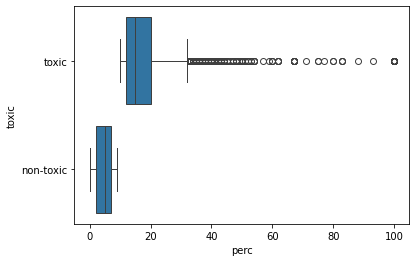

In [12]:
sns.boxplot(data=df, x="perc", y="toxic")

nel boxplot di perc si vede come la separazione delle "scatole" sia discriminante per la definizione della classe.
Meno le scatole si sovrappongono e meglio è

In [13]:
'''
for i in X_list:
    plt.figure()
    sns.boxplot(data=df, x=i, y="toxic")
'''

'\nfor i in X_list:\n    plt.figure()\n    sns.boxplot(data=df, x=i, y="toxic")\n'

In [14]:
boxplot_feature = ["toxic_posts","nbr_subreddit","extreme_toxic_group","moderated_toxic_group","obscene_toxic_group","fear_sum","anger_sum","negative_sum","disgust_sum","coleman_liau_sum","valence_sum","dumb_sum","stupid_sum","shit_sum","racist_sum","fuck_sum","idiot_sum","gay_sum","holy_sum","bitch_sum","toxic_words_sum","disgust_mean","flesch_kincaid_mean","coleman_liau_mean","dale_chall_mean","ari_mean","linsear_write_mean","spache_mean","trust_max","negative_max","arousal_max","tox_over"]

# mutual info k-best

In [15]:

X = df.drop(columns=["author","emotion_list","tox_list","toxic","toxic_annotation","perc"])
X_list = X.columns.to_list()
y = df["toxic"]

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [17]:
mutual_info = mutual_info_classif(X_train, y_train)

In [18]:
mutual_info = pd.Series(mutual_info)
mutual_info.index = X_train.columns
mutual_info.sort_values(ascending=False)

tox_over               0.458801
ratio_toxic            0.201730
extreme_toxic_group    0.119258
toxic_posts            0.112914
fuck_sum               0.100007
                         ...   
positive_min           0.000000
gunning_fog_sum        0.000000
anticip_min            0.000000
linsear_write_sum      0.000000
spache_max             0.000000
Length: 153, dtype: float64

In [19]:
mutual_feat = []
for k,v in mutual_info.items():
    if v>=0.1:
        mutual_feat.append(k)

In [20]:
mutual_feat

['toxic_posts', 'extreme_toxic_group', 'fuck_sum', 'tox_over', 'ratio_toxic']

In [21]:
features_impo = list(set(mutual_feat) | set(boxplot_feature))

In [22]:
len(features_impo)

33

In [23]:
features_impo

['anger_sum',
 'stupid_sum',
 'gay_sum',
 'fear_sum',
 'negative_sum',
 'disgust_mean',
 'bitch_sum',
 'coleman_liau_mean',
 'shit_sum',
 'ratio_toxic',
 'coleman_liau_sum',
 'tox_over',
 'nbr_subreddit',
 'toxic_words_sum',
 'extreme_toxic_group',
 'moderated_toxic_group',
 'holy_sum',
 'dale_chall_mean',
 'idiot_sum',
 'toxic_posts',
 'dumb_sum',
 'arousal_max',
 'fuck_sum',
 'flesch_kincaid_mean',
 'racist_sum',
 'disgust_sum',
 'obscene_toxic_group',
 'valence_sum',
 'spache_mean',
 'negative_max',
 'ari_mean',
 'linsear_write_mean',
 'trust_max']

In [24]:
X_sel = df.loc[:,features_impo]
y = df["toxic"]

In [25]:
X_sel.shape, y.shape

((15721, 33), (15721,))

In [26]:
X_sel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15721 entries, 0 to 15720
Data columns (total 33 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   anger_sum              15721 non-null  float64
 1   stupid_sum             15721 non-null  int64  
 2   gay_sum                15721 non-null  int64  
 3   fear_sum               15721 non-null  float64
 4   negative_sum           15721 non-null  float64
 5   disgust_mean           15721 non-null  float64
 6   bitch_sum              15721 non-null  int64  
 7   coleman_liau_mean      15721 non-null  float64
 8   shit_sum               15721 non-null  int64  
 9   ratio_toxic            15721 non-null  float64
 10  coleman_liau_sum       15721 non-null  float64
 11  tox_over               15721 non-null  int64  
 12  nbr_subreddit          15721 non-null  int64  
 13  toxic_words_sum        15721 non-null  int64  
 14  extreme_toxic_group    15721 non-null  int64  
 15  mo

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X_sel, y, test_size=0.3, random_state=42)

In [28]:
X_test.shape, X_train.shape, y_train.shape, y_test.shape

((4717, 33), (11004, 33), (11004,), (4717,))

In [29]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11004 entries, 13153 to 7270
Data columns (total 33 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   anger_sum              11004 non-null  float64
 1   stupid_sum             11004 non-null  int64  
 2   gay_sum                11004 non-null  int64  
 3   fear_sum               11004 non-null  float64
 4   negative_sum           11004 non-null  float64
 5   disgust_mean           11004 non-null  float64
 6   bitch_sum              11004 non-null  int64  
 7   coleman_liau_mean      11004 non-null  float64
 8   shit_sum               11004 non-null  int64  
 9   ratio_toxic            11004 non-null  float64
 10  coleman_liau_sum       11004 non-null  float64
 11  tox_over               11004 non-null  int64  
 12  nbr_subreddit          11004 non-null  int64  
 13  toxic_words_sum        11004 non-null  int64  
 14  extreme_toxic_group    11004 non-null  int64  
 15  mode

## DT

In [30]:
'''
param_grid = {
    "min_samples_split": uniform(0.0005,0.0003),
    "min_samples_leaf": uniform(0.004, 0.001),
    "max_depth": randint(2, 150),
    "criterion": ["gini", "entropy", "log_loss"],
    #"min_weight_fraction_leaf" : uniform(0.0001, 1e0),
    #"max_leaf_nodes" : randint(80, 140),
    #"min_impurity_decrease" : uniform(0.0001, 1e0),
    "ccp_alpha" : uniform(0.002, 0.0005)
}
grid = RandomizedSearchCV(
    DecisionTreeClassifier(),
    param_distributions=param_grid,
    cv=RepeatedStratifiedKFold(random_state=0),
    n_jobs=-1,
    n_iter=500,
)
grid.fit(X_train, y_train)
clf = grid.best_estimator_
'''

'\nparam_grid = {\n    "min_samples_split": uniform(0.0005,0.0003),\n    "min_samples_leaf": uniform(0.004, 0.001),\n    "max_depth": randint(2, 150),\n    "criterion": ["gini", "entropy", "log_loss"],\n    #"min_weight_fraction_leaf" : uniform(0.0001, 1e0),\n    #"max_leaf_nodes" : randint(80, 140),\n    #"min_impurity_decrease" : uniform(0.0001, 1e0),\n    "ccp_alpha" : uniform(0.002, 0.0005)\n}\ngrid = RandomizedSearchCV(\n    DecisionTreeClassifier(),\n    param_distributions=param_grid,\n    cv=RepeatedStratifiedKFold(random_state=0),\n    n_jobs=-1,\n    n_iter=500,\n)\ngrid.fit(X_train, y_train)\nclf = grid.best_estimator_\n'

In [31]:
#print(grid.best_params_, grid.best_score_)

In [32]:
#decision tree
dt = DecisionTreeClassifier(ccp_alpha = 0.0022, max_depth = 117, criterion = "gini", min_samples_leaf=0.0049,random_state=42)
dt.fit(X_train, y_train)

y_pred = dt.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred, digits=3))

Accuracy 0.9065083739665042
F1-score [0.91027467 0.90241204]
              precision    recall  f1-score   support

   non-toxic      0.888     0.933     0.910      2397
       toxic      0.927     0.879     0.902      2320

    accuracy                          0.907      4717
   macro avg      0.908     0.906     0.906      4717
weighted avg      0.908     0.907     0.906      4717



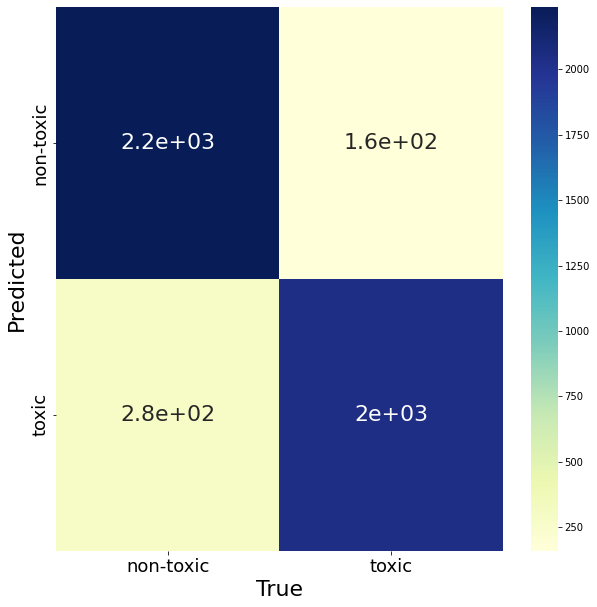

In [33]:
plt.figure(figsize=(10,10))
cf = confusion_matrix(y_test, y_pred)
sns.heatmap(cf, annot=True, cmap="YlGnBu",xticklabels = ["non-toxic", "toxic"], yticklabels = ["non-toxic", "toxic"], annot_kws={"size": 22})
plt.xlabel("True", fontsize=22)
plt.ylabel("Predicted", fontsize=22)
#plt.title("Decision Tree Confusion Matrix")
plt.xticks(fontsize=18)  # Aumenta il font dei tick sull'asse X
plt.yticks(fontsize=18)  # Aumenta il font dei tick sull'asse Y

plt.show()

<Figure size 720x720 with 0 Axes>

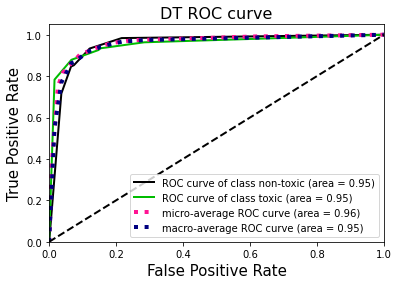

In [34]:
plt.figure(figsize = (10,10))
plot_roc(y_test, dt.predict_proba(X_test))
plt.xlabel("False Positive Rate", fontsize = 15)
plt.ylabel("True Positive Rate", fontsize = 15)
plt.title("DT ROC curve", fontsize = 16)
plt.show()

## KNN


In [35]:
#Scaling only on training set for entropy reasons
norm = StandardScaler()
norm.fit(X_train)
X_train_norm = norm.transform(X_train)
X_test_norm = norm.transform(X_test)


In [36]:
'''
param_grid = {
    "n_neighbors": randint(12,60),
    "weights": ["uniform", "distance"],
    "metric": ["manhattan", "euclidean", "minkowski"]
}

grid = RandomizedSearchCV(
    KNeighborsClassifier(),
    param_distributions=param_grid,
    cv=RepeatedStratifiedKFold(random_state=0),
    n_jobs=-1,
    n_iter = 50,
)
grid.fit(X_train_norm, y_train)
clf = grid.best_estimator_
'''

'\nparam_grid = {\n    "n_neighbors": randint(12,60),\n    "weights": ["uniform", "distance"],\n    "metric": ["manhattan", "euclidean", "minkowski"]\n}\n\ngrid = RandomizedSearchCV(\n    KNeighborsClassifier(),\n    param_distributions=param_grid,\n    cv=RepeatedStratifiedKFold(random_state=0),\n    n_jobs=-1,\n    n_iter = 50,\n)\ngrid.fit(X_train_norm, y_train)\nclf = grid.best_estimator_\n'

In [37]:
#print(grid.best_params_, grid.best_score_)

In [38]:
knn = KNeighborsClassifier(n_neighbors=34, metric="manhattan", weights = "distance")
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred, digits=3))

Accuracy 0.8906084375662497
F1-score [0.89712919 0.88320507]
              precision    recall  f1-score   support

   non-toxic      0.859     0.939     0.897      2397
       toxic      0.930     0.841     0.883      2320

    accuracy                          0.891      4717
   macro avg      0.895     0.890     0.890      4717
weighted avg      0.894     0.891     0.890      4717



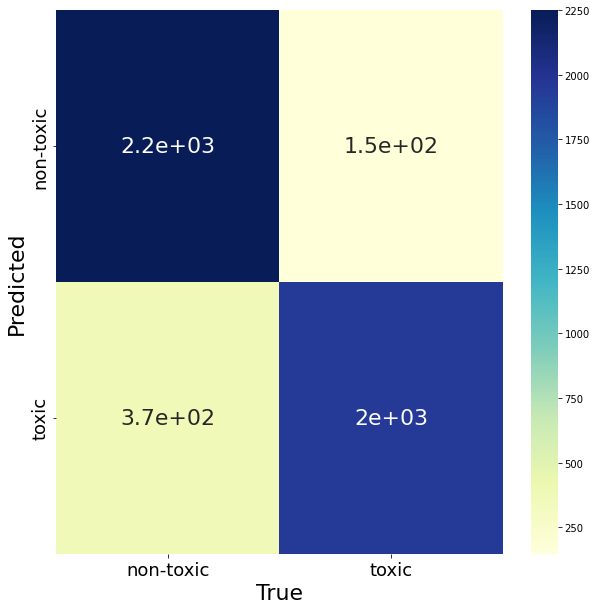

In [39]:
plt.figure(figsize=(10,10))
cf = confusion_matrix(y_test, y_pred)
sns.heatmap(cf, annot=True, cmap="YlGnBu",xticklabels = ["non-toxic", "toxic"], yticklabels = ["non-toxic", "toxic"], annot_kws={"size": 22})
plt.xlabel("True", fontsize=22)
plt.ylabel("Predicted", fontsize=22)
#plt.title("Decision Tree Confusion Matrix")
plt.xticks(fontsize=18)  # Aumenta il font dei tick sull'asse X
plt.yticks(fontsize=18)  # Aumenta il font dei tick sull'asse Y

plt.show()

<Figure size 720x720 with 0 Axes>

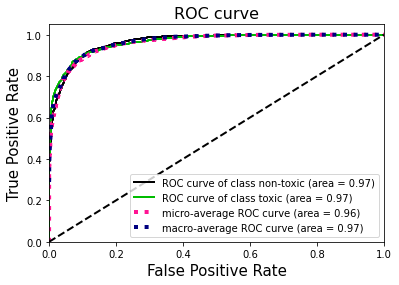

In [40]:
plt.figure(figsize = (10,10))
plot_roc(y_test, knn.predict_proba(X_test))
plt.xlabel("False Positive Rate", fontsize = 15)
plt.ylabel("True Positive Rate", fontsize = 15)
plt.title("ROC curve", fontsize = 16)
plt.show()

## Random Forest

In [41]:
'''
param_list = {'min_samples_split': [2, 5, 10, 20],
              'min_samples_leaf': [1, 5, 10, 20],
              'criterion': ["gini", "entropy"], # log_loss doesn't work
              'max_features': ["sqrt", "log2", None],
              'n_estimators': [int(x) for x in np.linspace(100,1000,num=10)],
              'class_weight': ["balanced", None, "balanced_subsample"]
             }

grid_rdmforest = RandomizedSearchCV(RandomForestClassifier(n_jobs=-1),
                    param_distributions=param_list,
                    cv=RepeatedStratifiedKFold(random_state=0, n_splits=3, n_repeats=5),
                    n_jobs=-1,
                    n_iter=100)
grid_rdmforest.fit(X_train, y_train)
'''

'\nparam_list = {\'min_samples_split\': [2, 5, 10, 20],\n              \'min_samples_leaf\': [1, 5, 10, 20],\n              \'criterion\': ["gini", "entropy"], # log_loss doesn\'t work\n              \'max_features\': ["sqrt", "log2", None],\n              \'n_estimators\': [int(x) for x in np.linspace(100,1000,num=10)],\n              \'class_weight\': ["balanced", None, "balanced_subsample"]\n             }\n\ngrid_rdmforest = RandomizedSearchCV(RandomForestClassifier(n_jobs=-1),\n                    param_distributions=param_list,\n                    cv=RepeatedStratifiedKFold(random_state=0, n_splits=3, n_repeats=5),\n                    n_jobs=-1,\n                    n_iter=100)\ngrid_rdmforest.fit(X_train, y_train)\n'

In [42]:
rf = RandomForestClassifier(n_estimators=100, 
                             criterion='gini', 
                             max_depth=None, 
                             min_samples_split=2, 
                             min_samples_leaf=1, 
                             min_weight_fraction_leaf=0.0, 
                             max_features='auto', 
                             random_state=0, 
                             n_jobs=-1,
                             class_weight="balanced_subsample")
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred, digits=3))


Accuracy 0.932372270510918
F1-score [0.93509664 0.92940916]
              precision    recall  f1-score   support

   non-toxic      0.913     0.959     0.935      2397
       toxic      0.955     0.905     0.929      2320

    accuracy                          0.932      4717
   macro avg      0.934     0.932     0.932      4717
weighted avg      0.933     0.932     0.932      4717



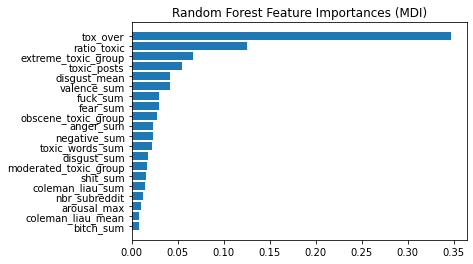

In [43]:
nbr_features = 20

tree_feature_importances = rf.feature_importances_
sorted_idx = tree_feature_importances.argsort()[-nbr_features:]

y_ticks = np.arange(0, len(sorted_idx))
fig, ax = plt.subplots(squeeze=True)
plt.barh(y_ticks, tree_feature_importances[sorted_idx])
plt.yticks(y_ticks, np.array(X_sel.columns)[sorted_idx])
plt.title("Random Forest Feature Importances (MDI)")
plt.show()

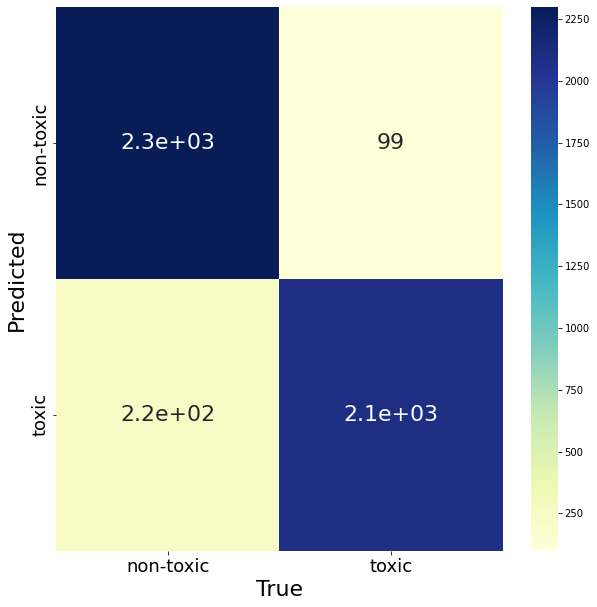

In [44]:
plt.figure(figsize=(10,10))
cf = confusion_matrix(y_test, y_pred)
sns.heatmap(cf, annot=True, cmap="YlGnBu",xticklabels = ["non-toxic", "toxic"], yticklabels = ["non-toxic", "toxic"], annot_kws={"size": 22})
plt.xlabel("True", fontsize=22)
plt.ylabel("Predicted", fontsize=22)
#plt.title("Decision Tree Confusion Matrix")
plt.xticks(fontsize=18)  # Aumenta il font dei tick sull'asse X
plt.yticks(fontsize=18)  # Aumenta il font dei tick sull'asse Y

plt.show()

<Figure size 720x720 with 0 Axes>

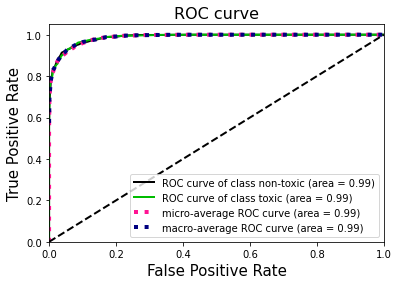

In [45]:
plt.figure(figsize = (10,10))
plot_roc(y_test, rf.predict_proba(X_test))
plt.xlabel("False Positive Rate", fontsize = 15)
plt.ylabel("True Positive Rate", fontsize = 15)
plt.title("ROC curve", fontsize = 16)
plt.show()

## SVM


In [46]:
svm = LinearSVC(C=0.07, class_weight = "balanced", random_state=42)
svm.fit(X_train, y_train)

y_pred = svm.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred, digits=3))


Accuracy 0.9277082891668433
F1-score [0.93232784 0.92241183]
              precision    recall  f1-score   support

   non-toxic      0.889     0.980     0.932      2397
       toxic      0.977     0.874     0.922      2320

    accuracy                          0.928      4717
   macro avg      0.933     0.927     0.927      4717
weighted avg      0.932     0.928     0.927      4717



/Users/jacopogneri/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


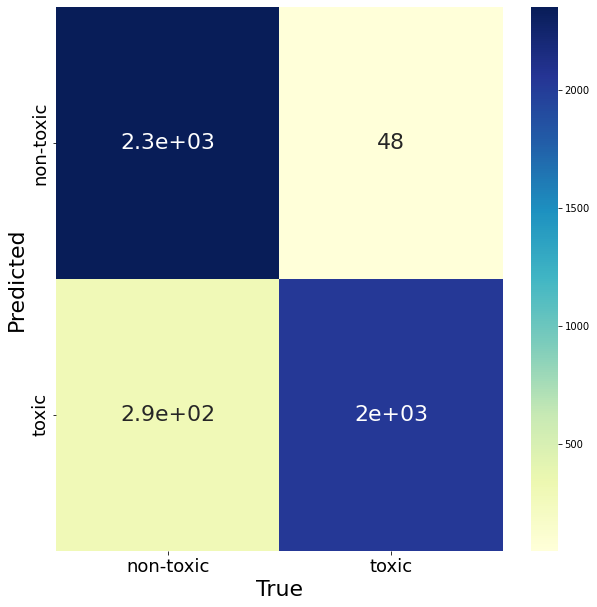

In [47]:
plt.figure(figsize=(10,10))
cf = confusion_matrix(y_test, y_pred)
sns.heatmap(cf, annot=True, cmap="YlGnBu",xticklabels = ["non-toxic", "toxic"], yticklabels = ["non-toxic", "toxic"], annot_kws={"size": 22})
plt.xlabel("True", fontsize=22)
plt.ylabel("Predicted", fontsize=22)
#plt.title("Decision Tree Confusion Matrix")
plt.xticks(fontsize=18)  # Aumenta il font dei tick sull'asse X
plt.yticks(fontsize=18)  # Aumenta il font dei tick sull'asse Y

plt.show()

# Logistic Regression

In [48]:
'''
param_grid = {
    "multi_class": ["multinomial", "ovr"],
    "C": loguniform(1e-5, 1),
    "class_weight": [None, "balanced"],
}
grid = RandomizedSearchCV(
    LogisticRegression(solver="saga"),
    param_distributions=param_grid,
    scoring="accuracy",
    cv=RepeatedStratifiedKFold(random_state=0),
    n_jobs=-1,
    n_iter=100,
)
grid.fit(X_train, y_train)
clf = grid.best_estimator_
'''

'\nparam_grid = {\n    "multi_class": ["multinomial", "ovr"],\n    "C": loguniform(1e-5, 1),\n    "class_weight": [None, "balanced"],\n}\ngrid = RandomizedSearchCV(\n    LogisticRegression(solver="saga"),\n    param_distributions=param_grid,\n    scoring="accuracy",\n    cv=RepeatedStratifiedKFold(random_state=0),\n    n_jobs=-1,\n    n_iter=100,\n)\ngrid.fit(X_train, y_train)\nclf = grid.best_estimator_\n'

In [49]:
log_reg = LogisticRegression(C=0.05, multi_class='multinomial', solver='saga', class_weight="balanced", max_iter=10000)
log_reg.fit(X_train, y_train)

y_pred = log_reg.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred, digits=3))


Accuracy 0.9366122535509858
F1-score [0.93856585 0.93453033]
              precision    recall  f1-score   support

   non-toxic      0.925     0.953     0.939      2397
       toxic      0.950     0.920     0.935      2320

    accuracy                          0.937      4717
   macro avg      0.937     0.936     0.937      4717
weighted avg      0.937     0.937     0.937      4717



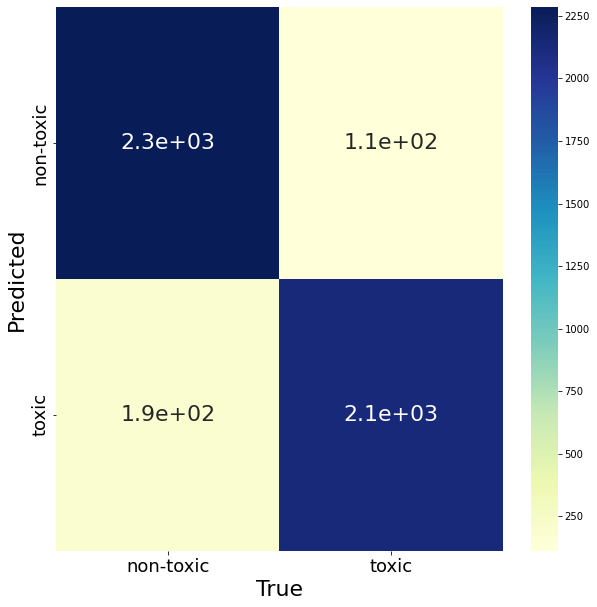

In [50]:
plt.figure(figsize=(10,10))
cf = confusion_matrix(y_test, y_pred)
sns.heatmap(cf, annot=True, cmap="YlGnBu",xticklabels = ["non-toxic", "toxic"], yticklabels = ["non-toxic", "toxic"], annot_kws={"size": 22})
plt.xlabel("True", fontsize=22)
plt.ylabel("Predicted", fontsize=22)
#plt.title("Decision Tree Confusion Matrix")
plt.xticks(fontsize=18)  # Aumenta il font dei tick sull'asse X
plt.yticks(fontsize=18)  # Aumenta il font dei tick sull'asse Y

plt.show()

<Figure size 720x720 with 0 Axes>

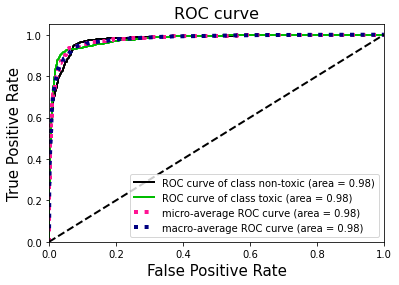

In [51]:
plt.figure(figsize = (10,10))
plot_roc(y_test, log_reg.predict_proba(X_test))
plt.xlabel("False Positive Rate", fontsize = 15)
plt.ylabel("True Positive Rate", fontsize = 15)
plt.title("ROC curve", fontsize = 16)
plt.show()

# XAI

SHAP used globally to highlight the most important features

In [52]:
#shap import
import shap
shap.initjs()

In [53]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4717 entries, 13564 to 4184
Data columns (total 33 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   anger_sum              4717 non-null   float64
 1   stupid_sum             4717 non-null   int64  
 2   gay_sum                4717 non-null   int64  
 3   fear_sum               4717 non-null   float64
 4   negative_sum           4717 non-null   float64
 5   disgust_mean           4717 non-null   float64
 6   bitch_sum              4717 non-null   int64  
 7   coleman_liau_mean      4717 non-null   float64
 8   shit_sum               4717 non-null   int64  
 9   ratio_toxic            4717 non-null   float64
 10  coleman_liau_sum       4717 non-null   float64
 11  tox_over               4717 non-null   int64  
 12  nbr_subreddit          4717 non-null   int64  
 13  toxic_words_sum        4717 non-null   int64  
 14  extreme_toxic_group    4717 non-null   int64  
 15  moder

In [54]:
%%time
#SUMMARY PLOT RF
class_names = ["non-toxic","toxic"]

explainer = shap.TreeExplainer(rf)

# Calcola i valori SHAP per il set di test
shap_values = explainer.shap_values(X_test)



CPU times: user 3min 20s, sys: 1.1 s, total: 3min 21s
Wall time: 3min 21s


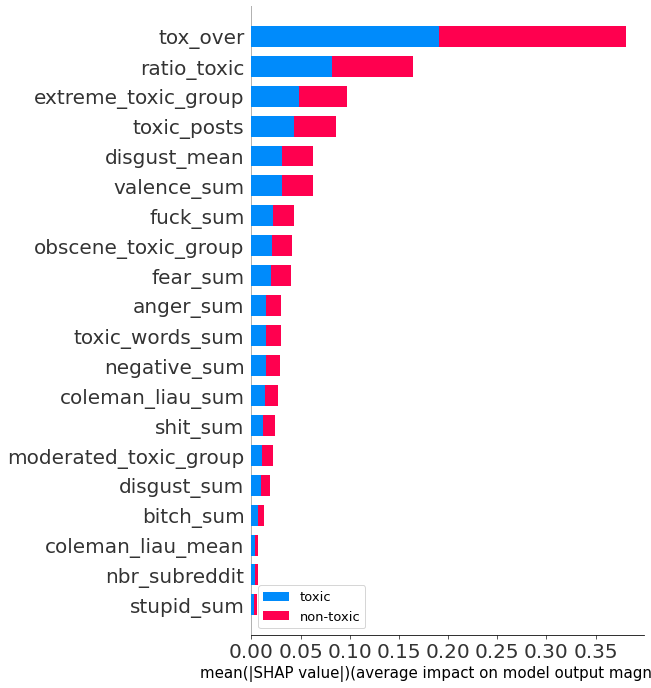

In [55]:
'''
fig = plt.figure(figsize=(20, 12))

shap.summary_plot(shap_values, X_test.values, plot_type="bar", class_names=class_names, feature_names = X_test.columns, show = False)

#plt.legend.set_size_inches(20,20)
plt.xticks(fontsize=20)  # Aumenta il font dei tick sull'asse X
plt.yticks(fontsize=20)  # Aumenta il font dei tick sull'asse Y
plt.legend(fontsize=20)
plt.xlabel("mean(|SHAP value|)(average impact on model output magnitude)", fontsize=15)
plt.legend(
    loc='right'
)
plt.legend(fontsize=13)
plt.show()
'''

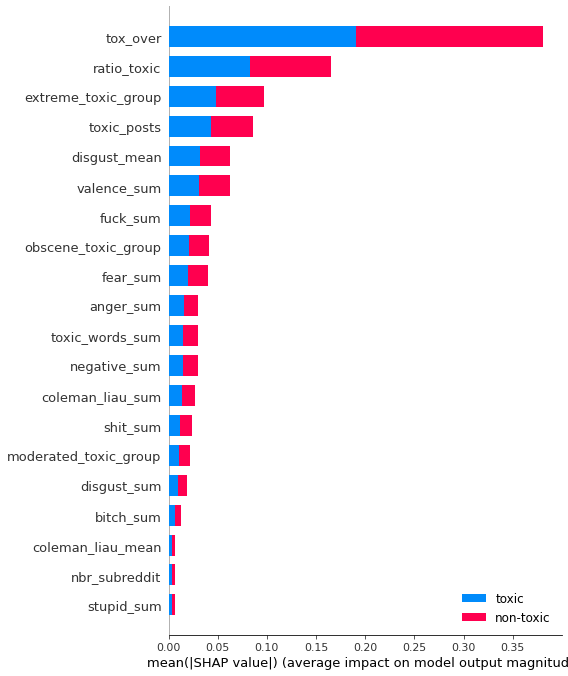

In [57]:
shap.summary_plot(shap_values, X_test.values, plot_type="bar", class_names=class_names, feature_names = X_test.columns, show = False)

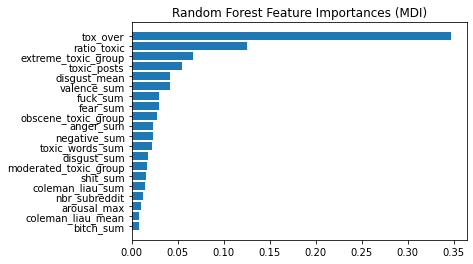

In [58]:
nbr_features = 20

tree_feature_importances = rf.feature_importances_
sorted_idx = tree_feature_importances.argsort()[-nbr_features:]

y_ticks = np.arange(0, len(sorted_idx))
fig, ax = plt.subplots(squeeze=True)
plt.barh(y_ticks, tree_feature_importances[sorted_idx])
plt.yticks(y_ticks, np.array(X_sel.columns)[sorted_idx])
plt.title("Random Forest Feature Importances (MDI)")
plt.show()
